In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn import datasets, linear_model
from tabulate import tabulate
import os

In [2]:
current_path = os.getcwd()
print(current_path)

d:\Work\04Script\01Oceanography\04ApiMarineCopernicus


In [3]:
def convert_csv(dataset, **kwargs):
    """
  Get CSV data from a dataset.
  Args:
    dataset: Set Path to Dataset File (.nc)
    **kwargs: Keyword arguments.
    **Keyword argument:**
    * `coor`: A list of two numbers specifying the [Longitude, Latitude] of the point to get the data for. 
    The coordinates should be in decimal degrees.

  
  Returns:
    A NumPy array containing the CSV data.
  """
    data = Dataset(rf'{dataset}.nc')
    lon = data.variables["longitude"][:].filled(np.nan)
    lat = data.variables["latitude"][:].filled(np.nan)
    vo = data.variables["vo"][:].filled(np.nan)
    uo = data.variables ["uo"][:].filled(np.nan)
    #zos = data.variables["zos"][:].filled(np.nan)

    time = data.variables["time"][:].filled(np.nan)
    time_unit = data.variables["time"].getncattr('units')
    local_time = num2date(time, units=time_unit,calendar='gregorian')

    cur_speed= np.sqrt(uo**2+vo**2)
    cur_dir = np.mod(180+(270-np.rad2deg(np.arctan2(vo, uo))),360)
    ext_lon = kwargs["coor"][0]
    ext_lat = kwargs["coor"][1]

    sq_dif_lon = (lon-ext_lon)**2
    sq_dif_lat = (lat-ext_lat)**2
    index_lon = sq_dif_lon.argmin()
    index_lat = sq_dif_lat.argmin()

    time_str = []
    for x in local_time:
      time_str.append(str(x))
    time_list = pd.to_datetime(pd.Series(time_str), format='%Y-%m-%d %H:%M:%S')

    d = {'time': time_list, 'velocity_(m/s)': cur_speed[:,index_lon, index_lat], 'direction_(deg)': cur_dir[:,index_lon, index_lat], 'uo': uo[:,index_lon, index_lat], 'vo': vo[:,index_lon, index_lat]}
    df = pd.DataFrame(data = d, index = None)
    df.to_csv(f'Hasil/{dataset}.csv')
    return df


In [76]:
def draw_graph(dataset, coor = [0.9, 104.3], time = False, title = 'Arus Laut'):
    df = convert_csv(dataset, coor = coor)

    if time == False:
        timestep = slice(None)
    else:
        start = time[0] - df['time'].iloc[0]
        start_time = int(start.total_seconds()/3600)
        end = time[1] - df['time'].iloc[0]
        end_time = int(end.total_seconds()/3600)
        timestep = slice(start_time,end_time)
    
    fig, ax1 = plt.subplots(1,2, figsize=(22,6), gridspec_kw={'width_ratios': [2, 1]})
    color = 'tab:blue'
    ax1[0].set_xlabel('Date')
    ax1[0].set_ylabel('Current_Speed (m/s)', color = color)
    ax1[0].plot(df['time'].iloc[timestep], df['velocity_(m/s)'].iloc[timestep], color = color)
    ax1[0].tick_params(axis='y', labelcolor = color)
    ax1[0].set_title(title)

    ax2 = ax1[0].twinx()
    color = 'tab:red'
    ax2.set_ylabel("Current_Direction (Deg)", color = color)
    ax2.plot(df['time'].iloc[timestep], df['direction_(deg)'].iloc[timestep], color = color)
    ax2.tick_params(axis='y', labelcolor = color)

    max_u = max(abs(df['uo']))
    max_v = max(abs(df['vo']))
    
    ax1[1].set_xlabel('U')
    ax1[1].set_ylabel('V')
    sc = ax1[1].scatter(df['uo'].iloc[timestep], df['vo'].iloc[timestep], c = df['velocity_(m/s)'].iloc[timestep], cmap = 'plasma', s = 3)
    ax1[1].axvline(0, c='black', ls='--')
    ax1[1].axhline(0, c='black', ls='--')
    ax1[1].set_xlim(-1*max_u, max_u)
    ax1[1].set_ylim(-1*max_v, max_v)
    plt.colorbar(sc, label = 'Current_Speed (m/s)')
    
    plt.show()

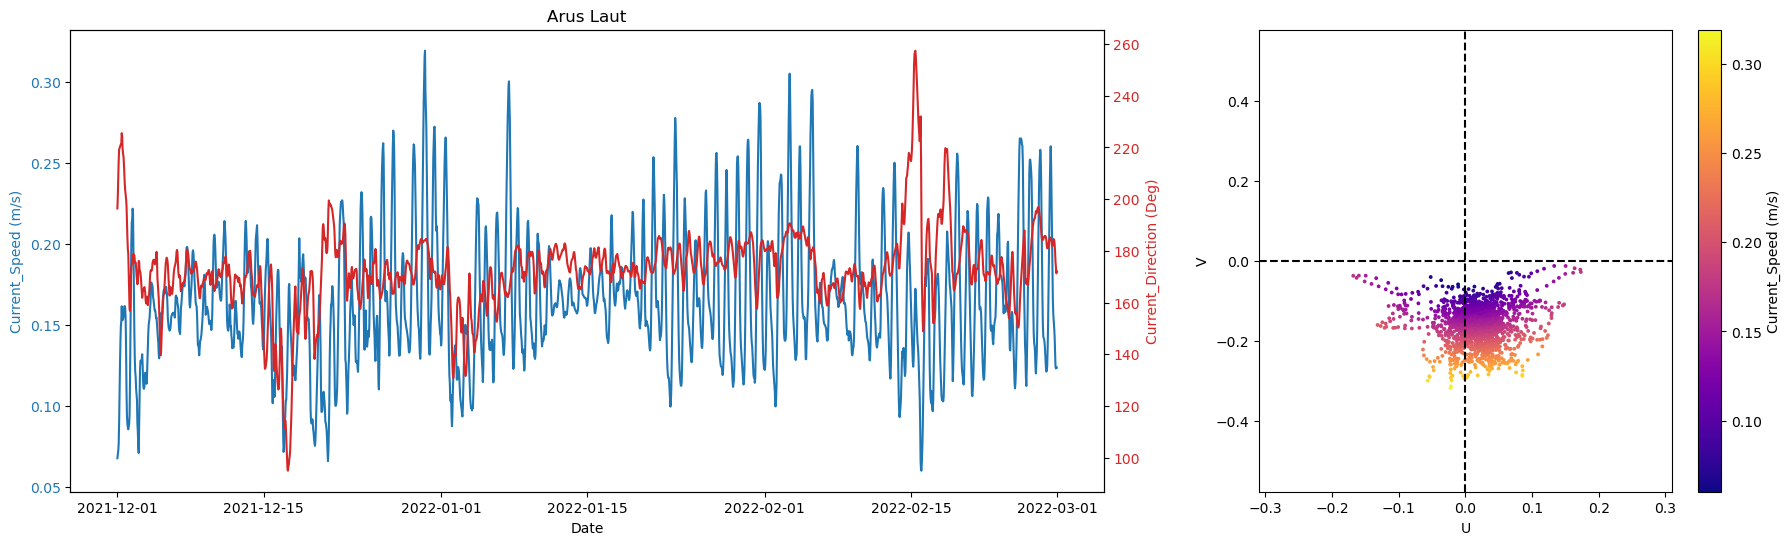

In [77]:
start_time = datetime(2021,12,1,00,00,00)
end_time = datetime(2022,3,1,00,00,00)

draw_graph('CMC_1y_current',coor = [0.9, 104.3], time = [start_time, end_time], title = "Arus Laut")